Изучение закономерностей, определяющих успешность игры
=====================================================

# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# Содержание проекта
### **1. Скачивание файла с данными и изучение общей информации**  
### **2. Предобработка данных**  
### **3. Исследовательский анализ**  
### **4. Портрет пользователя каждого региона**  
### **5. Проверка гипотез**  
### **6. Общий вывод**

## 1. Скачивание файла с данными и изучение общей информации

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings

In [2]:
# считаем файл и выведем пять строк
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
# проверим информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# проверим пропуски
data.isna().sum().sort_values(ascending = False)

Critic_Score       8578
Rating             6766
User_Score         6701
Year_of_Release     269
Name                  2
Genre                 2
Platform              0
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
dtype: int64

In [5]:
# проверим явные дубликаты
data.duplicated().sum()

0

**Вывод**

Для исследования предлагается таблица 11 столбцов х 16715 строк. Явные дубликаты отсутствуют. Обнаружены пропуски значений в некоторых столбцах - разберем их далее. Название каждого столбца нужно привести к нижнему регистру, у некоторых столбцов требуется преобразование типа данных.

## 2. Предобработка данных

In [6]:
# приведем столбцы в нижний регистр
data.columns = data.columns.str.lower()

In [7]:
# первым делом, проверим два пропуска в столбце name
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Удалим эти две строки, набор данных в них бесмысленный - похоже на тех. сбой.

In [8]:
data = data.dropna(subset=['name'])

Тип данных столбцов year_of_release, critic_score, user_score необходимо поменять.
Для этого последовательно исследуем пропуски в данных столбцах.

В столбце year_of_release пропущено всего ~1,5% значений. Ревьюер предыдущего проекта дал рекомендацию удалять строки с пропусками, если их относительное количество от общего числа строк датафрейма меньше 10%. В нашем случае по данному столбцу ~98,5% данных заполнено корректно - этого более чем достаточно для исследования.

In [9]:
data = data.dropna(subset=['year_of_release'])

In [10]:
# проверим сколько строк удалилось (визуально)
data.shape[0]

16444

271 строка удалена - корректно. Единичные пропуски удалены.


В столбцах, которые связаны с рейтингом и оценками, не так все просто. Пропуски явно не случайны и просто удалить их нельзя - слишком много строк. В качестве причин можем предположить: отсутствие площадок для оценки игр в 80-е/90-е и слабое их развитие в 00-е годы. Также игры непопулярных жанров оценивали мало пользователей и критиков (не было данных для средневзвешенной оценки) или не оценивали вовсе. Проверим уникальные значения в столбцах critic_score, user_score, rating. 

In [11]:
data.critic_score.unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

In [12]:
data.user_score.unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [13]:
data.rating.unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Оценку пользователя и критика мы не можем заменить на медиану или среднее, так как речь идет о разных эпохах, этапах развития игровой отрасли, разных поколениях игроков и критиков. Заменим пропуски на нулевые значения.

In [14]:
data[['critic_score','user_score']] = data[['critic_score','user_score']].fillna(0)

В столбце rating есть только единственный вариант обработки - поставить заглушку вместо пропуска. 

In [15]:
data['rating'] = data['rating'].fillna('no_rating')

tbd - to be determined, заменим на ноль. Это равносильно пропуску и значение непредсказуемо (заменим на медиану - можем сильно не угадать)

In [16]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = ""
data['user_score'] = pd.to_numeric(data['user_score'])

In [17]:
data.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score          0
user_score         2376
rating                0
dtype: int64

Пропусков больше нет.

Добавляем столбец world_sales - суммарные продажи в мире. 

In [18]:
data['world_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales']+data['other_sales']
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,0.0,no_rating,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,no_rating,31.38


Завершаем предобработку данных преобразованием типов: year_of_release, critic_score - ставим целочисленный, user_score - вещественный тип.

In [19]:
data['year_of_release']=data['year_of_release'].astype('int')
data['critic_score']=data['critic_score'].astype('int')
data['user_score']=data['user_score'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       14068 non-null  float64
 10  rating           16444 non-null  object 
 11  world_sales      16444 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


**Вывод**

- привели названия колонок к нижнему регистру
- заменили типы данных в годе выпуска, оценке критиков и оценке пользователей
- пропуски в оценках были заменены на 0 из-за отсутствие значения
- в столбце рейтинга использовали заглушку при заполнении пропусков
- добавили столбец с мировыми продажами
- заменили типы данных в годе выпуска, оценке критиков и пользователей

## 3. Исследовательский анализ данных

**Сколько игр выпускалось в разные годы**

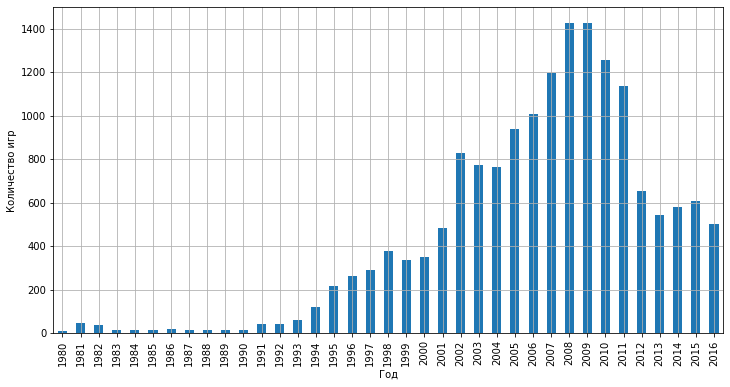

In [20]:
data.groupby('year_of_release')['name'].count().plot(kind='bar',figsize=(12,6))
plt.xlabel('Год', fontsize=10)
plt.ylabel('Количество игр', fontsize=10)
plt.grid()
plt.show()

**Вывод:**
Гистограмма показывает, что максимальные значения по количеству выпускаемых игр приходятся на 2008-2009 года, с 2010 года начинается спад, который идет вплоть до 2016 года. Период с 1980 по 1990 года не имеет тенденции к росту, в это время индустрия зарождается, развивается, обучаются разработчики, наращивается аудитория нового вида развлечения.

**Продажи по платформам и распределение продаж популярных платформ по годам**

In [21]:
sales = data.groupby('platform')['world_sales'].sum().sort_values(ascending=False)
sales = sales[:10]

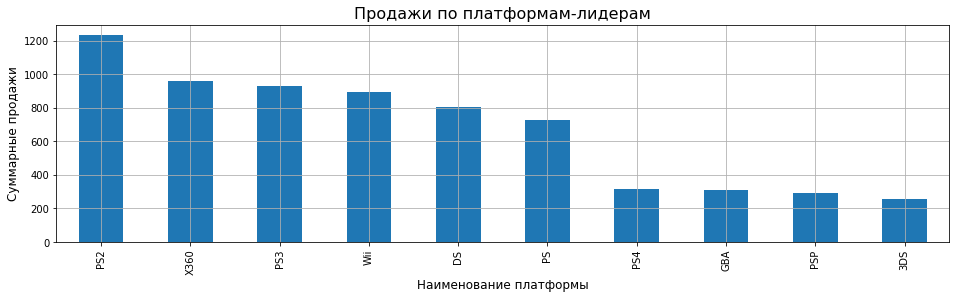

In [22]:
sales.plot(kind='bar',figsize=(16,4))

plt.title('Продажи по платформам-лидерам',fontsize = 16)
plt.xlabel("Наименование платформы", fontsize=12)
plt.ylabel('Суммарные продажи', fontsize=12)
plt.grid()
plt.show()

Лидерами продаж являются платформы: PS2, X360, PS3, Wii, DS, PS. Максимальные суммарные продажи принесла платформа PS2

In [23]:
# доп. сводная таблица для составления рейтинга продаж по платформам
platform_top = data.pivot_table(index='platform', values='world_sales', aggfunc='sum')\
                .query('world_sales > world_sales.quantile(0.75)').sort_values(by='world_sales',ascending=False)
top = list(platform_top.index)

In [24]:
# доп. сводная таблица для для общего графика продаж платформ лидеров
platform_sales = data.pivot_table(index='year_of_release',columns='platform',values='world_sales',aggfunc='sum')
platform_top_sales = platform_sales.loc[:, top]

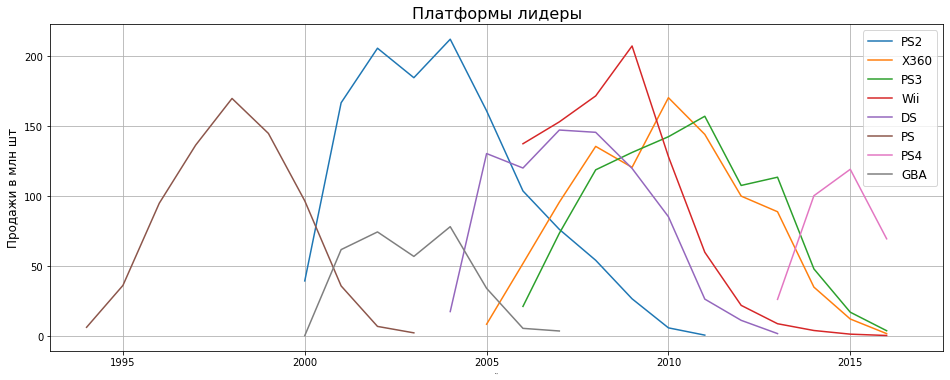

In [25]:
# график по
plt.figure(figsize=(16,6))
plt.plot(platform_top_sales.index, platform_top_sales)
plt.title('Платформы лидеры',fontsize = 16)
plt.xlim(left=1993)
plt.ylabel('Продажи в млн шт',fontsize = 12)
plt.xlabel('Год',fontsize = 2)
plt.legend(platform_top_sales,loc='upper right', fontsize=12)
plt.grid()
plt.show()

**Вывод по графику:**
Возможно график перегружен данными, но он явно отображает жизненный цикл платформы. Есть начальная точка, затем рост продаж, максимум, затем падение продаж и конечная точка (закрытие продаж на платформе). С начала жизни игровой индустрии лидировали продукты SONY - PS и PS2. После 2005 года лидерами стали Wii (Nintendo) и Xbox (Microsoft). Для сохранения интереса пользователей производители создавали новые игровые платформы на базе предыдущих (PS-PS2-PS3-PS4).

**За какой характерный срок появляются новые и исчезают старые платформы?**

In [26]:
platform_lifetime = data.groupby('platform').agg({'year_of_release':['min','max']})
platform_lifetime.columns = ['year_min','year_max']
platform_lifetime['lifetime'] = platform_lifetime['year_max']-platform_lifetime['year_min']+1

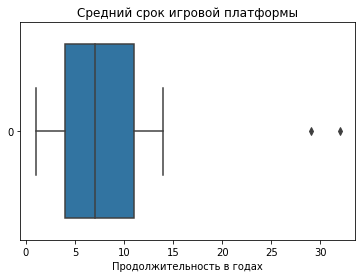

In [27]:
# построим  ящик с усами
sns.boxplot(data=platform_lifetime['lifetime'], orient='h')
plt.title('Средний срок игровой платформы')
plt.xlabel('Продолжительность в годах')
plt.show()

In [28]:
# проверим медиану
platform_lifetime['lifetime'].median()

7.0

На момент года платформа PS4 была на спаде, но вполне "жива". Рассмотрим среднее значение по платформам, закрытым раньше 2016 года.

In [29]:
platform_lifetime.query('year_max < 2016')['lifetime'].mean()

8.0

**Вывод:**
Средняя продолжительность "жизни" игровой платформы 8 лет. При этом есть платформы, которые на момент 2016 года еще не закрылись.

**Определение актуального периода для прогнозирования данных на 2017 год**

Вряд ли аналитик - не геймер сможет досконально понять потребности покупателей и пользователей различных платформ. А именно чем сейчас руководствуются пользователи при выборе и покупке, какие их ожидания от игр. Например, по датасету непонятно как выглядит игра на той или иной современной платформе и чем она вызывает интерес своего пользователя и формирует пул покупателей. Поэтому, если руководствоваться только цифрами - работать и делать прогноз считаю нужным только по актуальным платформам. Не вижу смысл прогнозировать по DS и Wii (хоть они и достаточно современны и по-своему актуальны) - они попали в топ-10 и прошли имели пик продаж, но к 2016 году их продажи почти сошли на ноль. Будем отталкиваться от главного соперничества последних лет, которое двигает игровую индустрию - Xbox и PS (3-я и 4-я версии). Актуальным периодом примем 2013 - 2016 г.

In [30]:
# актуальные данные запишем в новый датафрейм
actual_data = data.query('year_of_release >= 2013') 

**Какие платформы лидируют по продажам**

In [31]:
# сформируем сводник по актуальным данным
actual_sales = actual_data.pivot_table(index='year_of_release',columns='platform',values='world_sales',aggfunc='sum')
actual_sales

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


In [32]:
# plt.figure(figsize=(16,6))

# plt.plot(actual_sales.index, actual_sales)

# plt.title('Продажи игр по платформам',fontsize = 20)

# plt.ylabel('Продажи в млн шт',fontsize = 12)
# plt.xlabel('Год выпуска',fontsize = 12)
# plt.legend(actual_sales,loc='upper right', fontsize=12)
# plt.grid()
# plt.xticks([2013, 2014, 2015, 2016])
# plt.show()


<Figure size 1152x432 with 0 Axes>

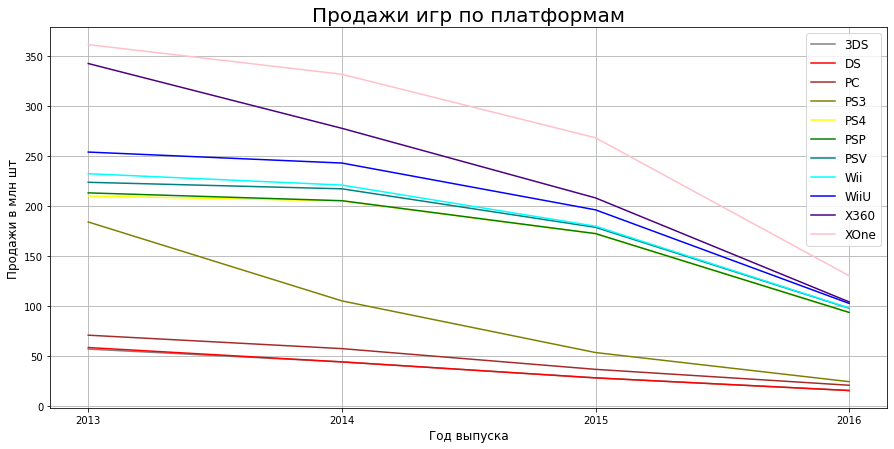

In [33]:
plt.figure(figsize=(16,6))

colors = ['grey', 'red', 'brown', 'olive', 'yellow', 'green', 'teal', 'aqua', 'blue', 'indigo', 'pink', 'peru', 'purple', 'khaki', 'violet', 'crimson', 'skyblue', 'tomato']
actual_sales.plot(kind='line', figsize=(15,7), stacked=True, color=colors)
plt.title('Продажи игр по платформам',fontsize = 20)

plt.ylabel('Продажи в млн шт',fontsize = 12)
plt.xlabel('Год выпуска',fontsize = 12)
plt.legend(actual_sales,loc='upper right', fontsize=12)
plt.grid()
plt.xticks([2013, 2014, 2015, 2016])
plt.show()

Мы видим 10 актуальных платформ. На первом месте PS4, на втором XOne, на третьем 3DS. Продажи всех платформ снизились к 2016 году. 

In [34]:
platform_lifetime.query('year_max > 2013').sort_values('lifetime', ascending=False)

,year_min,year_max,lifetime
platform,,,
PC,1985,2016,32
PSP,2004,2015,12
X360,2005,2016,12
PS3,2006,2016,11
Wii,2006,2016,11
3DS,2011,2016,6
PSV,2011,2016,6
WiiU,2012,2016,5
PS4,2013,2016,4


5 платформ превысили среднюю продолжительность жизни. PC - номинальный "лидер". Предположение из предыдущих разделов подтверждается  - ориентироваться по прогнозу нужно на Xbox и PS.  


**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.**


(0.0, 2.0)

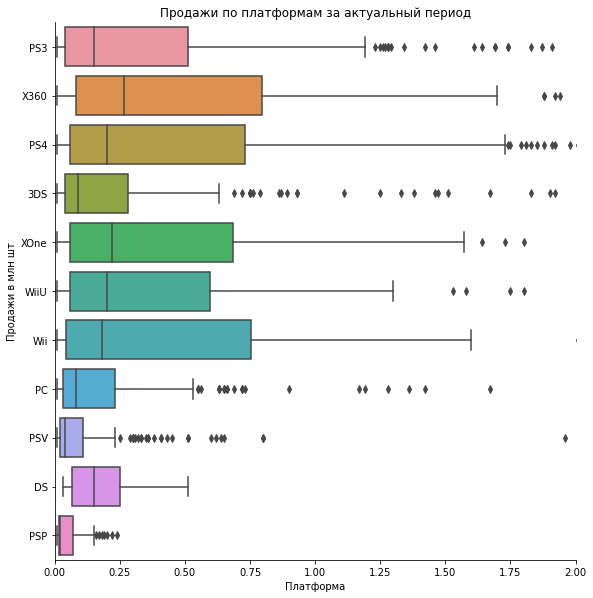

In [35]:
sns.catplot(x='world_sales', 
            y='platform', 
            kind="box", 
            data=actual_data, 
            orient='h',
            height=8)
plt.title('Продажи по платформам за актуальный период')
plt.xlabel('Платформа')
plt.ylabel('Продажи в млн шт')
plt.xlim(0, 2)

**Вывод** 
Видим, что за выбранный актуальный период (2013-2016 годы) продажи игр не достигают миллиона штук. Но существуют явные выбросы - игры-хиты с миллионными продажами. Особо отличаются игры на PS4, X360 и Wii.

**Влияние на продажи отзывов пользователей и критиков. На примере одной популярной платформы.**

Исследуем платформу PS4. Исключим игры без оценки критиков и пользователей (значение ноль)

In [36]:
ps4_cr = data.query('platform == "PS4" and critic_score >0')
ps4_cr.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87,6.5,M,7.17


In [37]:
ps4_us = data.query('platform == "PS4" and user_score >0')
ps4_us.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,world_sales
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83,5.7,M,7.66
94,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85,5.0,E,7.60
105,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87,6.5,M,7.17


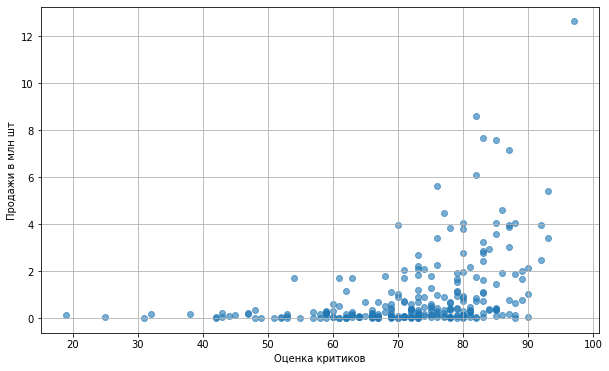

In [38]:
# построим две диаграммы рассеяния
fig,ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = ps4_cr['critic_score'], y = ps4_cr['world_sales'], alpha=0.6)
plt.xlabel("Оценка критиков")
plt.ylabel("Продажи в млн шт")
plt.grid()
plt.show()

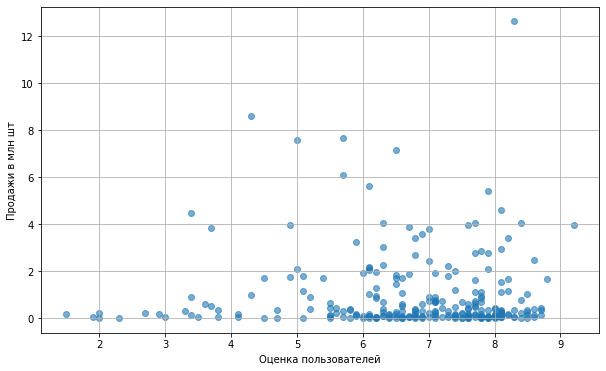

In [39]:
fig,ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = ps4_us['user_score'], y = ps4_us['world_sales'], alpha=0.6)
plt.xlabel("Оценка пользователей")
plt.ylabel("Продажи в млн шт")
plt.grid()
plt.show()

In [40]:
# коэффициент корреляции оценки критиков и продаж
round(ps4_cr['critic_score'].corr(ps4_cr['world_sales']),2)

0.41

In [41]:
# коэффициент корреляции оценки игроков и продаж
round(ps4_us['user_score'].corr(ps4_us['world_sales']),2)

-0.03

Коэффициент корреляции - 0,41 указывает на крайне слабую зависимость между оценкой критиков и продажами игр. Оценка пользователей и продажи не зависят друг от друга (коэффициент корреляции -0,03).

Проверим наши выводы на продажах игр других платформ. 

In [42]:
for name in actual_data['platform'].unique():
    
    user = data.query('platform == @name and user_score >0')
    critic = data.query('platform == @name and critic_score >0')

    user_corr = round(user['user_score'].corr(user['world_sales']),2)
    critic_corr = round(critic['critic_score'].corr(critic['world_sales']),2)
    print('----------------------------------------')
    print('Платформа:', name)
    print('Коэф. корреляции между продажами и отзывами критиков:', critic_corr)
    print('Коэф. корреляции между продажами и отзывами игроков:', user_corr)
    print('----------------------------------------')

----------------------------------------
Платформа: PS3
Коэф. корреляции между продажами и отзывами критиков: 0.43
Коэф. корреляции между продажами и отзывами игроков: 0.13
----------------------------------------
----------------------------------------
Платформа: X360
Коэф. корреляции между продажами и отзывами критиков: 0.39
Коэф. корреляции между продажами и отзывами игроков: 0.11
----------------------------------------
----------------------------------------
Платформа: PS4
Коэф. корреляции между продажами и отзывами критиков: 0.41
Коэф. корреляции между продажами и отзывами игроков: -0.03
----------------------------------------
----------------------------------------
Платформа: 3DS
Коэф. корреляции между продажами и отзывами критиков: 0.35
Коэф. корреляции между продажами и отзывами игроков: 0.22
----------------------------------------
----------------------------------------
Платформа: XOne
Коэф. корреляции между продажами и отзывами критиков: 0.42
Коэф. корреляции между про

В целом выводы для PS4 также применимы к большинству платформ. Но есть и небольшие отличия. Например, портативные консоли (PSP, 3DS) все же зависят (слабо) от оценок пользователей, коэффициент корреляции отличен от нуля. Также, платформа WiiU имеет умеренную зависимость от оценок критиков и игроков - коэффициенты почти равны. 

**Общее распределение игр по жанрам**


In [43]:
genre_sales = actual_data.groupby('genre').agg({'world_sales':['count', 'sum']})

genre_sales.columns=['games','sales']
genre_sales['rate'] = genre_sales['sales']/genre_sales['games']
genre_sales.sort_values(('games'), ascending=False)

,games,sales,rate
genre,,,
Action,766,321.87,0.420196
Role-Playing,292,145.89,0.499623
Adventure,245,23.64,0.096490
Sports,214,150.65,0.703972
Shooter,187,232.98,1.245882
Misc,155,62.82,0.405290
Racing,85,39.89,0.469294
Fighting,80,35.31,0.441375
Platform,74,42.63,0.576081


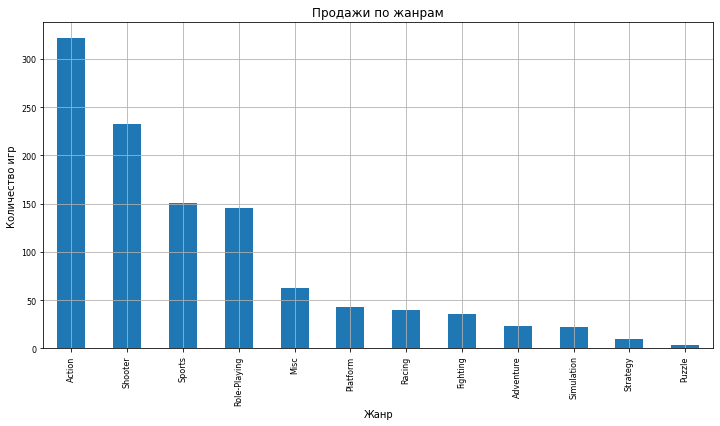

In [44]:
# построим гистограмму
genre_sales['sales'].sort_values(ascending = False).plot(kind='bar',fontsize=8,figsize=(12,6))
plt.title('Продажи по жанрам')
plt.xlabel('Жанр', fontsize=10)
plt.ylabel('Количество игр', fontsize=10)
plt.grid()
plt.show()

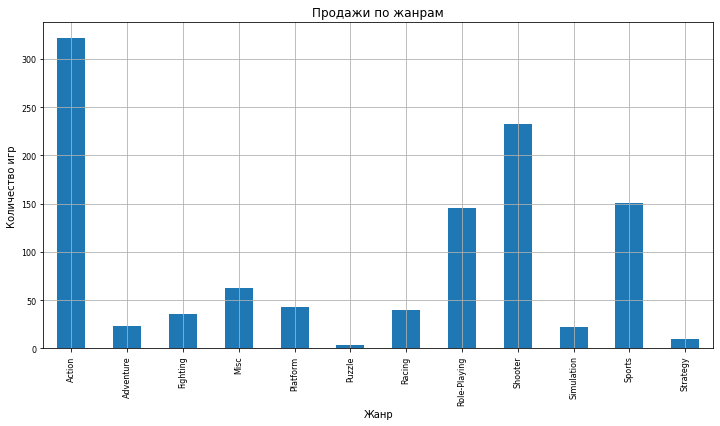

In [45]:
genre_sales['sales'].plot(kind='bar',fontsize=8,figsize=(12,6))
plt.title('Продажи по жанрам')
plt.xlabel('Жанр', fontsize=10)
plt.ylabel('Количество игр', fontsize=10)
plt.grid()
plt.show()

Лидеры продаж - жанры Action и Shooter. Аутсайдеры - Puzzle и Strategy. 

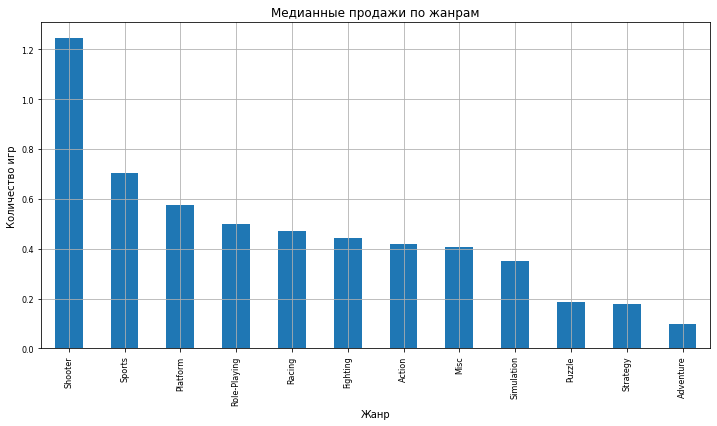

In [46]:
genre_sales['rate'].sort_values(ascending = False).plot(kind='bar',fontsize=8,figsize=(12,6))
plt.title('Медианные продажи по жанрам')
plt.xlabel('Жанр', fontsize=10)
plt.ylabel('Количество игр', fontsize=10)
plt.grid()
plt.show()

Лидеры абсолютных продаж - жанры Shooter и Sports. Аутсайдеры - Adventure и Strategy. Медианные продажи совпали лишь частично, но жанр Shooter - остался в топе лидеров, а Strategy - в аутсайдерах. 

**Вывод**

В качестве summary приведем основные тезисы исследовательского анализа датасета:
- Максимальные значения по количеству выпускаемых игр приходятся на 2008-2009 года, с 2010 года начинается спад
- Лидерами продаж являются платформы: PS2, X360, PS3, Wii. Жизненый цикл платформы - 8 лет.
- Главное соперничество последних лет, которое двигает игровую индустрию - Xbox против PS. Поэтому актуальным выбран период 2013 - 2016 г.
- Продажи по платформам за актуальный период: на первом месте PS4, на втором XOne, на третьем 3DS.
- Коэффициенты корреляции указывают на умеренную зависимость между оценкой критиков и продажами игр и независимость оценки пользователей и продаж.
- По жанрам: лидеры продаж по двум показателям - Shooter. Аутсайдер - Strategy. Анализ подтвержает интуитивную логику - игры, где нужно больше думать и планировать - менее популярны. 


## 4. Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

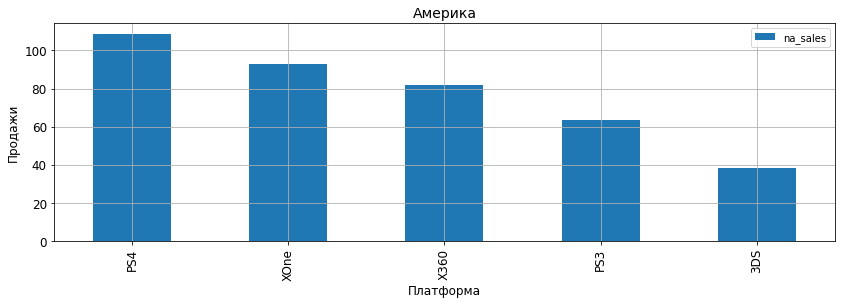

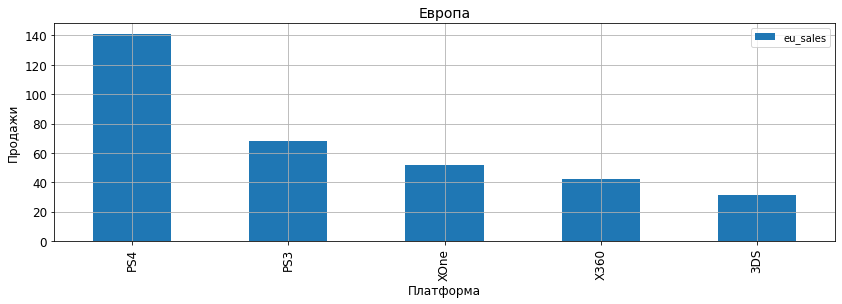

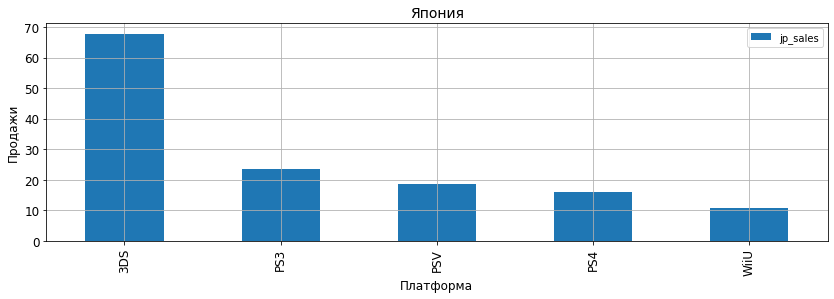

In [47]:
# Популярные платформы для региона NA
na_sales = actual_data.pivot_table(index='platform',values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)[:5]
na_sales.plot(kind='bar',figsize=(14,4))
plt.xlabel("Платформа", fontsize=12)
plt.ylabel('Продажи', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Америка', fontsize=14)
plt.grid()
plt.show()

# Популярные платформы для региона EU
eu_sales = actual_data.pivot_table(index='platform',values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)[:5]
eu_sales.plot(kind='bar',figsize=(14,4))
plt.xlabel("Платформа", fontsize=12)
plt.ylabel('Продажи', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Европа', fontsize=14)
plt.grid()
plt.show()

# Популярные платформы для региона JP
jp_sales = actual_data.pivot_table(index='platform',values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)[:5]
jp_sales.plot(kind='bar',figsize=(14,4))
plt.xlabel("Платформа", fontsize=12)
plt.ylabel('Продажи', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Япония', fontsize=14)
plt.grid()
plt.show()


In [48]:
# посчитаем долю продаж в Америке 
total_sales = actual_data.pivot_table(index='platform', values='world_sales', aggfunc='sum') 
per_sales_na = (na_sales['na_sales'] / total_sales['world_sales']* 100)
print('Доля продаж в Америке:\n', per_sales_na.sort_values(ascending=False)[:5])
print("--------------------")
# посчитаем долю продаж в Европе 
per_sales_eu = (eu_sales['eu_sales'] / total_sales['world_sales']* 100) 
print('Доля продаж в Европе:\n', per_sales_eu.sort_values(ascending=False)[:5])
print("--------------------")
# посчитаем долю продаж в Японии
per_sales_jp = (jp_sales['jp_sales'] / total_sales['world_sales']* 100)
print('Доля продаж в Японии:\n', per_sales_jp.sort_values(ascending=False)[:5])

Доля продаж в Америке:
 platform
X360    59.692982
XOne    58.448406
PS3     34.999724
PS4     34.615140
3DS     26.666667
dtype: float64
--------------------
Доля продаж в Европе:
 platform
PS4     44.913096
PS3     37.375296
XOne    32.381371
X360    31.081871
3DS     21.612565
dtype: float64
--------------------
Доля продаж в Японии:
 platform
PSV     56.350409
3DS     47.336824
WiiU    16.834287
PS3     12.869977
PS4      5.080537
dtype: float64


**Вывод:**
В Америке и Европе пользуются спросом одни и те же игровые платформы, а у японцев - японские игровые платформы. Игровые платформы PS3-4, 3DS пользуются спросом во всех регионах. В Японии в топ не попала консоль Xbox.
По долям продаж можно судить, что японцы обладают своим менталитетом - больше предпочитают портативные консоли. Они помешаны на работе, и явно могут поиграть только в короткие перерывы или в транспорте. Дома нет времени на игры. Американцы  предпочитают "отечественное" - приставку Xbox от Microsoft. А рынок Европы больше покорили консоли от Sony (PS4, PS3).

Исследуем жанры.

In [49]:
actual_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum') .sort_values(by='eu_sales', ascending=False)[:5]

,eu_sales
genre,
Action,118.13
Shooter,87.86
Sports,60.52
Role-Playing,36.97
Racing,20.19


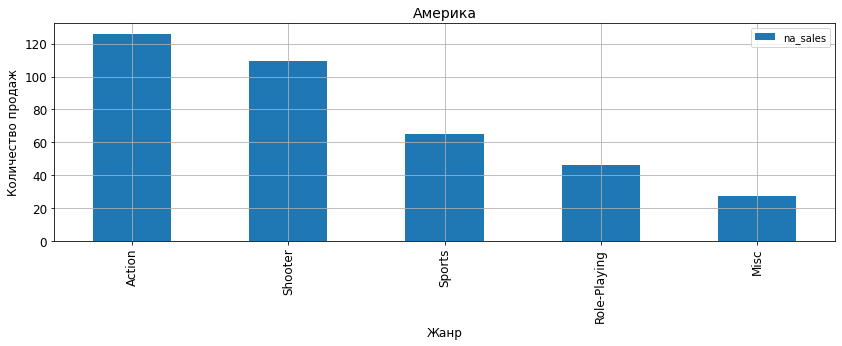

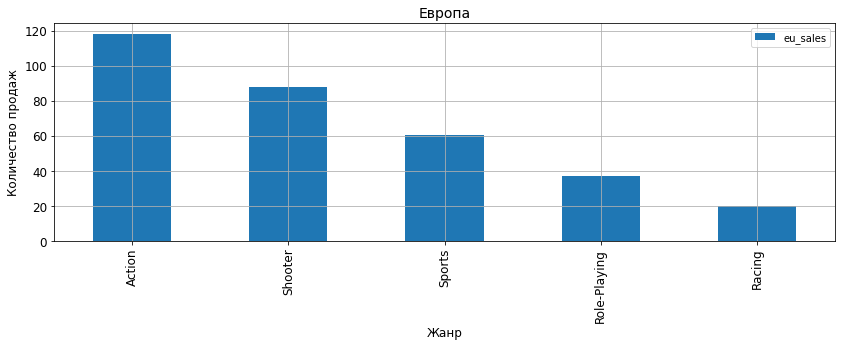

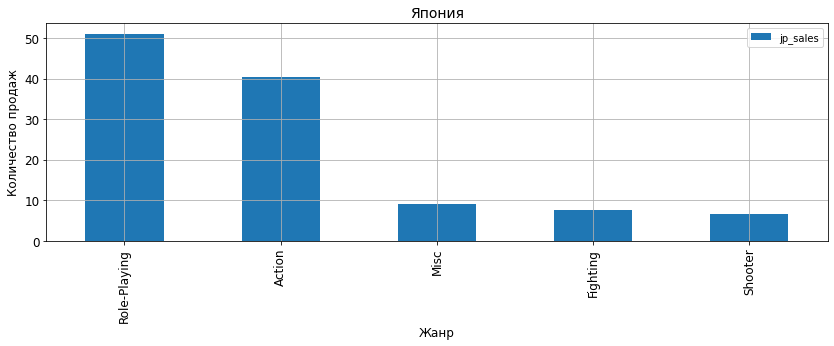

In [50]:
# популярные жанры в Северной Америке
actual_data.pivot_table(index='genre', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False)[:5].plot(kind='bar',figsize=(14,4))
plt.xlabel("Жанр", fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Америка', fontsize=14)
plt.grid()

# популярные жанры в Европе
actual_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)[:5].plot(kind='bar',figsize=(14,4))
plt.xlabel("Жанр", fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Европа', fontsize=14)
plt.grid()

# популярные жанры в Японии
actual_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)[:5].plot(kind='bar',figsize=(14,4))
plt.xlabel("Жанр", fontsize=12)
plt.ylabel('Количество продаж', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Япония', fontsize=14)
plt.grid()
plt.show()

**Вывод:** Японцы выделились и здесь - их топ-5 отличается от Европы и Америки. Role-playning, Action, Shooter - фигурирует в топ-5 во всех регионах. Предпочтения Америки и Европы почти совпадает.

**Влияение рейтинга ESRB на продажи в отдельном регионе**


In [51]:
na_rating = actual_data.groupby('rating',as_index=False)['na_sales'].sum()
eu_rating = actual_data.groupby('rating',as_index=False)['eu_sales'].sum()
jp_rating = actual_data.groupby('rating',as_index=False)['jp_sales'].sum()

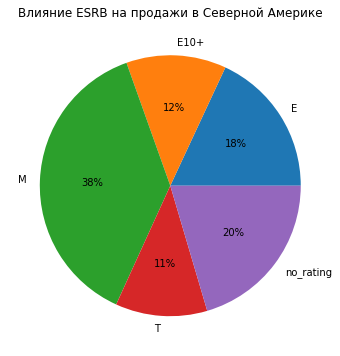

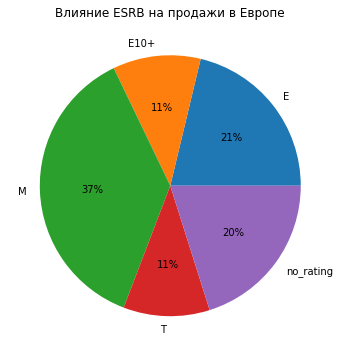

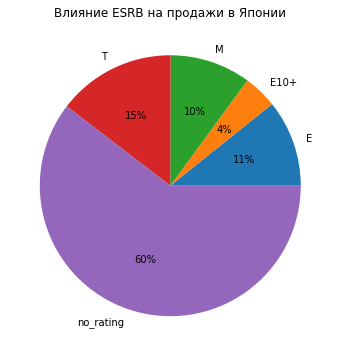

In [52]:
na_rating.plot(kind='pie',y="na_sales", autopct='%1.0f%%', legend=False, labels=na_rating['rating'],
               title = "Влияние ESRB на продажи в Северной Америке", figsize=(6,6),ylabel='')
eu_rating.plot(kind='pie',y="eu_sales", autopct='%1.0f%%', legend=False, labels=eu_rating['rating'],
               title = "Влияние ESRB на продажи в Европе", figsize=(6,6),ylabel='')
jp_rating.plot(kind='pie',y="jp_sales", autopct='%1.0f%%', legend=False, labels=jp_rating['rating'],
               title = "Влияние ESRB на продажи в Японии", figsize=(6,6),ylabel='');

**Вывод** Доля рейтингов у Европы и Северной Америки мало различаются. На первом месте рейтинг «M» — «Для взрослых». Сюда входит все, что запрещено младшей аудитории (насилие, кровь, секс и так далее). Соответствует популярным жанрам Action Shooter. В Японии около 60% игр вообще не имеют рейтинга поскольку ESRB не является обязательным и принадлежит Америке.

## 5. Проверка гипотез

**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**


Осуществим проверку гипотез о равенстве средних двух генеральных совокупностей (двухстороннюю): сначала формулируется нулевая гипотеза H₀ о равенстве, далее формулируется альтернативная гипотеза, опровергающая утверждение H₀.

Сформулируем гипотезы:

Нулевая гипотеза H₀: средние пользовательские рейтинги платформ Xbox One и PC не различаются
Альтернативная гипотеза H₁: средние пользовательские рейтинги платформ Xbox One и PC различаются

In [53]:
# две выборки данных
xone = actual_data.query('platform == "XOne" and user_score > 0')
pc = actual_data.query('platform == "PC" and user_score > 0')

In [54]:
# средние рейтинги
print(xone['user_score'].mean())
print(pc['user_score'].mean())

6.521428571428572
6.2696774193548395


In [55]:
# проверим гипотезу
alpha = .05

results = st.ttest_ind(xone['user_score'], pc['user_score'], equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


**Средние пользовательские рейтинги жанров Action и Sports разные**


Сформулируем гипотезы:

Нулевая гипотеза H₀: Средние пользовательские рейтинги жанров Action и Sports не различаются
Альтернативная гипотеза H₁: Средние пользовательские рейтинги жанров Action и Sports различаются

In [56]:
# две выборки данных
action = actual_data.query('genre == "Action" and user_score > 0')
sports = actual_data.query('genre == "Sports" and user_score > 0')

In [57]:
# средние рейтинги
print(action['user_score'].mean())
print(sports['user_score'].mean())

6.837532133676092
5.238124999999999


In [58]:
alpha = .05

results = st.ttest_ind(action['user_score'], sports['user_score'], equal_var = False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  1.4460039700704315e-20
Отвергаем нулевую гипотезу


**Вывод**

- "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые" - С высокой вероятностью пользовательские оценки для платформ будут одинаковыми.
- "Средние пользовательские рейтинги жанров Action и Sports разные" - С высокой вероятностью мы получим разные оценки для жанров.

## 6. Общий вывод

В качестве общего summary обозначим некоторые промежуточные выводы. 

Для исследования предоставлены данные по выпуску и продаже игр за период 1980 - 2016 годы. Пики выпуска новых игр и продаж приходится на 2008-2009 годы.  Далее мы видим снижение и выпуска и продаж. Возможно, связано с появлением и развитием игр для смартфонов.

Самыми продаваемыми игровыми платформами за все время являются PS и Xbox. В свое время лидером был Nintendo. Разработчики своевременно производят новые платформы, заменяя старые. 

На всем изучаемом периоде количество игровых платформ менялось. Средняя продолжительность жизни игровой платформы 8 лет. Последний пик роста количества игровых платформ приходится на 2013 год , затем идет снижение. 

Для большинства платформ справедливо утверждение: на продажи игр в небольшой степени влияют оценки критиков и не влияют оценки игроков.

При планировании продаж на 2017 год, необходимо ориентироваться на игровые платформы PS4 и XOne.

В Америке и Европе следует обращать внимание на игры в жанрах Action или Shooter. В Японии - RPg. Влияние на итоговые продажи могутоказать оценки критиков. Оценки игроков таким влиянием не обладают.

В целом можно сказать, что по аналогии с 2016 годом можно ожидать 2 -кратное падение продаж.

Доля рейтингов у Европы и Северной Америки мало различаются. На первом месте рейтинг «M» — «Для взрослых». В Японии - свой рейтинг, не представленный в датасете.

Наиболее прибыльный жанр - Shooter (по медианным продажам). Аутсайдер - Стратегия.

<a id='result-1'></a>